# Ethereum Blockchain Explorer
Some functions to help explore the ethereum blockchain using JSON RPC on the BlockScience geth node

In [2]:
import requests, json
import pandas as pd
SESSION = requests.Session()
f = open("mk_node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT

## Basic JSON downloading

In [3]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [4]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [5]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [6]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [7]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [8]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [9]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [10]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [11]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [12]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [13]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [14]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [15]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [16]:
################################################################################
# high-level methods
################################################################################

In [17]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def transfer(from_, to, amount):
    '''
    Send wei from one address to another
    '''
    return eth_sendTransaction(from_address=from_, to_address=to, value=amount)

In [18]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def create_contract(from_, code, gas, sig=None, args=None):
    '''
    Create a contract on the blockchain from compiled EVM code. Returns the
    transaction hash.
    '''
    from_ = from_ or eth_coinbase()
    if sig is not None and args is not None:
         types = sig[sig.find('(') + 1: sig.find(')')].split(',')
         encoded_params = encode_abi(types, args)
         code += encoded_params.encode('hex')
    return eth_sendTransaction(from_address=from_, gas=gas, data=code)

In [19]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def get_contract_address(tx):
    '''
    Get the address for a contract from the transaction that created it
    '''
    receipt = eth_getTransactionReceipt(tx)
    return receipt['contractAddress']

In [20]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call(address, sig, args, result_types):
    '''
    Call a contract function on the RPC server, without sending a
    transaction (useful for reading data)
    '''
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    response = eth_call(to_address=address, data=data_hex)
    return decode_abi(result_types, response[2:].decode('hex'))

In [21]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call_with_transaction(from_, address, sig, args, gas=None, gas_price=None, value=None):
    '''
    Call a contract function by sending a transaction (useful for storing
    data)
    '''
    gas = gas or DEFAULT_GAS_PER_TX
    gas_price = gas_price or DEFAULT_GAS_PRICE
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    return eth_sendTransaction(from_address=from_, to_address=address, data=data_hex, gas=gas,
                                    gas_price=gas_price, value=value)

In [22]:
################################################################################
# JSON-RPC methods
################################################################################

In [23]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_clientVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_clientversion
    NEEDS TESTING
    '''
    return _call('web3_clientVersion')

In [24]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [25]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_version
    NEEDS TESTING
    '''
    return _call('net_version')

In [26]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_listening():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_listening
    NEEDS TESTING
    '''
    return _call('net_listening')

In [27]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_peerCount():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_peercount
    NEEDS TESTING
    '''
    return hex_to_dec(_call('net_peerCount'))

In [28]:
def eth_protocolVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_protocolversion
    NEEDS TESTING
    '''
    return _call('eth_protocolVersion')

In [29]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_syncing():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_syncing
    TESTED - MARKUS 2018-02-07
    '''
    return _call('eth_syncing')

In [30]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_coinbase():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_coinbase
    NEEDS TESTING
    '''
    return _call('eth_coinbase')

In [31]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_mining():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_mining
    NEEDS TESTING
    '''
    return _call('eth_mining')

In [32]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_hashrate():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_hashrate
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_hashrate'))

In [33]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_gasPrice():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gasprice
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_gasPrice'))

In [34]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_accounts():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_accounts
    NEEDS TESTING
    '''
    return _call('eth_accounts')

In [35]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [36]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBalance(address=None, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getbalance
    TESTED - MARKUS 2018-02-07
    '''
    address = address or eth_coinbase()
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBalance', [address, block]))

In [37]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getStorageAt(address=None, position=0, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getstorageat
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getStorageAt', [address, hex(position), block])

In [38]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionCount(address, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactioncount
    TESTED - MARKUS 2018-02-07
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getTransactionCount', [address, block]))

In [39]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbyhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getBlockTransactionCountByHash', [block_hash]))

In [40]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBlockTransactionCountByNumber', [block]))

In [41]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblockhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getUncleCountByBlockHash', [block_hash]))

In [42]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblocknumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getUncleCountByBlockNumber', [block]))

In [43]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCode(address, default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcode
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    return _call('eth_getCode', [address, default_block])

In [44]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sign(address, data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sign
    NEEDS TESTING
    '''
    return _call('eth_sign', [address, data])

In [45]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendTransaction(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                        nonce=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendtransaction
    NEEDS TESTING
    '''
    params = {}
    params['from'] = from_address or eth_coinbase()
    if to_address is not None:
        params['to'] = to_address
    if gas is not None:
        params['gas'] = hex(gas)
    if gas_price is not None:
        params['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        params['value'] = clean_hex(value)
    if data is not None:
        params['data'] = data
    if nonce is not None:
        params['nonce'] = hex(nonce)
    return _call('eth_sendTransaction', [params])

In [46]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendRawTransaction(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendrawtransaction
    NEEDS TESTING
    '''
    return _call('eth_sendRawTransaction', [data])

In [47]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [48]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_estimateGas(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                    default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_estimategas
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    if to_address is not None:
        obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return hex_to_dec(_call('eth_estimateGas', [obj, default_block]))

In [49]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [50]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [51]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [52]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByBlockHashAndIndex', [block_hash, hex(index)])

In [53]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getTransactionByBlockNumberAndIndex', [block, hex(index)])

In [54]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [55]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getUncleByBlockHashAndIndex', [block_hash, hex(index)])

In [56]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getUncleByBlockNumberAndIndex', [block, hex(index)])

In [57]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCompilers():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcompilers
    NEEDS TESTING
    '''
    return _call('eth_getCompilers')

In [58]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSolidity(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilesolidity
    NEEDS TESTING
    '''
    return _call('eth_compileSolidity', [code])

In [59]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileLLL(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilelll
    N/A
    '''
    return _call('eth_compileLLL', [code])

In [60]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSerpent(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compileserpent
    N/A
    '''
    return _call('eth_compileSerpent', [code])

In [61]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newFilter(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_newFilter', [_filter])

In [62]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newBlockFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newblockfilter
    NEEDS TESTING
    '''
    return _call('eth_newBlockFilter')

In [63]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newPendingTransactionFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newpendingtransactionfilter
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_newPendingTransactionFilter'))

In [64]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_uninstallfilter
    NEEDS TESTING
    '''
    return _call('eth_uninstallFilter', [filter_id])

In [65]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterchanges
    NEEDS TESTING
    '''
    return _call('eth_getFilterChanges', [filter_id])

In [66]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterLogs(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
    NEEDS TESTING
    '''
    return _call('eth_getFilterLogs', [filter_id])

In [67]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [68]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getWork():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getwork
    NEEDS TESTING
    '''
    return _call('eth_getWork')

In [69]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitWork(nonce, header, mix_digest):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submitwork
    NEEDS TESTING
    '''
    return _call('eth_submitWork', [nonce, header, mix_digest])

In [70]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitHashrate(hash_rate, client_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submithashrate
    NEEDS TESTING
    '''
    return _call('eth_submitHashrate', [hex(hash_rate), client_id])

In [71]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_version
    N/A
    '''
    return _call('shh_version')

In [72]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_post(topics, payload, priority, ttl, from_=None, to=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_post
    NEEDS TESTING
    '''
    whisper_object = {
        'from':     from_,
        'to':       to,
        'topics':   topics,
        'payload':  payload,
        'priority': hex(priority),
        'ttl':      hex(ttl),
    }
    return _call('shh_post', [whisper_object])

In [73]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newIdentity():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newidentity
    N/A
    '''
    return _call('shh_newIdentity')

In [74]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_hasIdentity(address):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_hasidentity
    NEEDS TESTING
    '''
    return _call('shh_hasIdentity', [address])

In [75]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newgroup
    N/A
    '''
    return _call('shh_newGroup')

In [76]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_addToGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_addtogroup
    NEEDS TESTING
    '''
    return _call('shh_addToGroup')

In [77]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newFilter(to, topics):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'to':     to,
        'topics': topics,
    }
    return _call('shh_newFilter', [_filter])

In [78]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_uninstallfilter
    NEEDS TESTING
    '''
    return _call('shh_uninstallFilter', [filter_id])

In [79]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getfilterchanges
    NEEDS TESTING
    '''
    return _call('shh_getFilterChanges', [filter_id])

In [80]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getMessages(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getmessages
    NEEDS TESTING
    '''
    return _call('shh_getMessages', [filter_id])    

In [81]:
eth_syncing()

False

In [82]:
eth_blockNumber()

5054453

In [83]:
eth_getBalance(address='0x267be1C1D684F78cb4F6a176C4911b741E4Ffdc0')

130559626958801795550644

In [84]:
eth_getTransactionCount('0x267be1C1D684F78cb4F6a176C4911b741E4Ffdc0')

762440

In [85]:
tokens = {
    '0xc66ea802717bfb9833400264dd12c2bceaa34a6d': 'MKR',
    '0xe41d2489571d322189246dafa5ebde1f4699f498': 'ZRX',
    '0x27054b13b1b798b345b591a4d22e6562d47ea75a': 'AST',
    '0x2956356cd2a2bf3202f771f50d3d14a367b48070': 'Canon WETH',
    '0xecf8f87f810ecf450940c9f60066b4a7a501d6a7': 'WrappedETH-MKR',
    '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'WETH',
    '0x744d70fdbe2ba4cf95131626614a1763df805b9e': 'SNT',
    '0xa74476443119a942de498590fe1f2454d7d4ac0d': 'Golem',
    '0xbb9bc244d798123fde783fcc1c72d3bb8c189413': 'TheDAO',
    '0xa74476443119a942de498590fe1f2454d7d4ac0d': 'GNT',
    '0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359': 'Dai 1.0',
    '0x59adcf176ed2f6788a41b8ea4c4904518e62b6a4': 'Sai'
    }

In [86]:
MEW_TOKENS = getJSON('https://raw.githubusercontent.com/MyEtherWallet/ethereum-lists/master/tokens/tokens-eth.json')

In [87]:
ERC20_transfer_signature = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef' 
DAI_address = '0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359'
DAI_transfer_filter = eth_newFilter(address=DAI_address, topics=[ERC20_transfer_signature])
latest_block = eth_blockNumber()
delta_blocks = 10000
recent_DAI_transfers_JSON = eth_getLogs(from_block=hex(latest_block-delta_blocks), address=DAI_address, topics=[ERC20_transfer_signature])

In [88]:
recent_DAI_transfers = pd.DataFrame.from_dict(recent_DAI_transfers_JSON)
recent_DAI_transfers['amount'] = recent_DAI_transfers['data'].apply(lambda x: float.fromhex(x)*1e-18)
recent_DAI_transfers['from'] = recent_DAI_transfers['topics'].apply(lambda x: x[1])
recent_DAI_transfers['to'] = recent_DAI_transfers['topics'].apply(lambda x: x[2])
recent_DAI_transfers.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,amount,from,to
0,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0xbce7248b8adf2b46b16f056c7894440bf7c611ac4664...,0x4cf8ef,0x00000000000000000000000000000000000000000000...,0x5a,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x6c0193fbce8dc467241fd8ced11beabd939753e53027...,0x97,3860.000000,0x0000000000000000000000000734e30d680f2923d10f...,0x000000000000000000000000143e79a9e576fddb5de9...
1,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x92c379d89a2ec09df88048459aed726399a95679ba05...,0x4cf8f5,0x00000000000000000000000000000000000000000000...,0x2c,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xda4180f8a31256dd831a72e1148b63bf202ec062b539...,0x82,1.002289,0x000000000000000000000000578f3c8454f316293dbd...,0x000000000000000000000000f87a7ec94884f44d9de3...
2,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x92c379d89a2ec09df88048459aed726399a95679ba05...,0x4cf8f5,0x00000000000000000000000000000000000000000000...,0x2e,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xda4180f8a31256dd831a72e1148b63bf202ec062b539...,0x82,1.002289,0x000000000000000000000000f87a7ec94884f44d9de3...,0x0000000000000000000000007edaa1c379a5a389fb15...
3,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x92c379d89a2ec09df88048459aed726399a95679ba05...,0x4cf8f5,0x00000000000000000000000000000000000000000000...,0x32,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x8e9f16f2709230ee649708efb1e79ba42d52419e2d04...,0x86,10925.000000,0x0000000000000000000000000734e30d680f2923d10f...,0x000000000000000000000000c0ba9fd6fd13b87f71cf...
4,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0xe634f4e0977598322b5ef95e9a62452d876de5bcb60e...,0x4cf945,0x00000000000000000000000000000000000000000000...,0x4b,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xeb82f1872dc4d384819f1e3528a7532f836898099796...,0x78,10200.000000,0x0000000000000000000000003c8cfc48fca36cd7e0a2...,0x000000000000000000000000f87a7ec94884f44d9de3...


In [89]:
recent_DAI_transfers.describe()

,amount
count,1.222000e+03
mean,2.139080e+04
std,2.948064e+04
min,3.000000e-18
25%,1.112820e+03
50%,1.801187e+04
75%,4.000000e+04
max,5.000000e+05


In [94]:
import numpy as np
%matplotlib inline

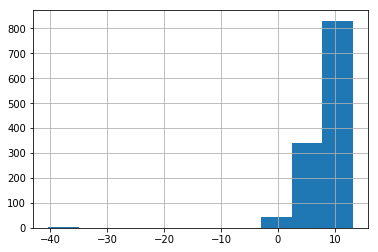

In [97]:
recent_DAI_transfers.amount.apply(lambda x: np.log(x)).hist()

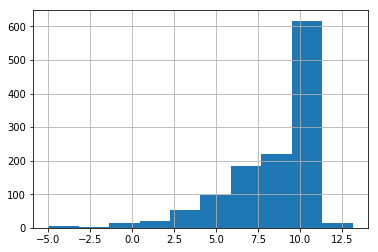

In [98]:
recent_DAI_transfers.amount.apply(lambda x: np.clip(np.log(x), -5,15)).hist()